The Kalman filter used in this example is a linear, time-invariant (LTI) state-space model. It is not autoregressive in the traditional sense, but rather it is a recursive estimation algorithm that uses a series of noisy measurements over time to estimate the hidden state of a linear dynamical system. The model consists of two main parts: the state-transition model and the observation model.

The state-transition model describes how the true state evolves over time:

x(t) = F x(t-1) + G w(t)

where x(t) is the state vector at time t, F is the state-transition matrix, G is the input matrix, and w(t) is the process noise, which is assumed to be Gaussian with zero mean and covariance Q.

The observation model relates the state to the noisy measurements:

z(t) = H x(t) + v(t)

where z(t) is the measurement vector at time t, H is the observation matrix, and v(t) is the measurement noise, which is also assumed to be Gaussian with zero mean and covariance R.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns



In [39]:

def kalman_filter(z, x0, P0, F, G, H, Q, R, dim):
    """
    Kalman filter for state estimation.

    Parameters:
    z (array): Measurements (shape: n_samples x dim)
    x0 (array): Initial state estimate (shape: dim)
    P0 (array): Initial state covariance matrix (shape: dim x dim)
    F (array): State transition matrix (shape: dim x dim)
    G (array): Control input matrix (unused in this implementation, shape: dim x control_dim)
    H (array): Observation matrix (shape: dim x dim)
    Q (array): Process noise covariance matrix (shape: dim x dim)
    R (array): Measurement noise covariance matrix (shape: dim x dim)
    dim (int): Dimension of the state

    Returns:
    x (array): Estimated states (shape: n_samples x dim)
    """

    n_samples = len(z)
    x = np.zeros((n_samples, dim))
    P = np.zeros((n_samples, dim, dim))

    x[0] = x0
    P[0] = P0

    for t in range(1, n_samples):
        # Prediction step
        x_pred = F @ x[t - 1]  # Predict the next state based on the previous state and the state transition matrix F
        P_pred = F @ P[t - 1] @ F.T + Q  # Predict the next state covariance matrix based on the previous state covariance matrix, the state transition matrix F, and the process noise covariance matrix Q

        # Update step
        y = z[t] - H @ x_pred  # Calculate the difference between the measurement and the predicted state (called innovation)
        S = H @ P_pred @ H.T + R  # Calculate the innovation covariance matrix using the observation matrix H, the predicted state covariance matrix, and the measurement noise covariance matrix R
        K = P_pred @ H.T @ np.linalg.inv(S)  # Calculate the Kalman gain, which determines how much the innovation should be weighted in the state update
        x[t] = x_pred + K @ y  # Update the state estimate by combining the predicted state and the weighted innovation
        P[t] = P_pred - K @ H @ P_pred  # Update the state covariance matrix by incorporating the information from the innovation

    return x


    return x
def fgsm_adversarial_perturbation(z, x0, P0, F, G, H, Q, R, epsilon, dim):
    """
    Computes adversarial perturbation for measurements using the Fast Gradient Sign Method (FGSM).

    Parameters:
    z (array): Measurements (shape: n_samples x dim)
    x0 (array): Initial state estimate (shape: dim)
    P0 (array): Initial state covariance matrix (shape: dim x dim)
    F (array): State transition matrix (shape: dim x dim)
    G (array): Control input matrix (unused in this implementation, shape: dim x control_dim)
    H (array): Observation matrix (shape: dim x dim)
    Q (array): Process noise covariance matrix (shape: dim x dim)
    R (array): Measurement noise covariance matrix (shape: dim x dim)
    epsilon (float): Strength of the perturbation
    dim (int): Dimension of the state

    Returns:
    delta_z (array): Adversarial perturbation (shape: n_samples x dim)
    """

    n_samples = len(z)
    delta_z = np.zeros_like(z)

    x = x0
    P = P0

    for t in range(n_samples):
        # Prediction step
        x_pred = F @ x
        P_pred = F @ P @ F.T + Q
        #print(P_pred)

        # Compute gradient of the loss function w.r.t. measurements
        S_inv = np.linalg.inv(H @ P_pred @ H.T + R)  # Calculate the inverse of the innovation covariance matrix
        grad_loss = -2 * (z[t] - H @ x_pred) * H @ P_pred @ H.T @ S_inv  # Calculate the gradient of the loss function w.r.t. measurements
        grad_loss = np.sum(grad_loss, axis=1)  # Sum the gradient over the dimensions to obtain a 1D array

        # Generate adversarial perturbation using FGSM
        delta_z[t] = epsilon * np.sign(grad_loss)  # Use the sign of the gradient to generate the perturbation

        # Update the measurement with adversarial perturbation
        z_adv = z[t] + delta_z[t]

        # Update step
        y = z_adv - H @ x_pred  # Calculate the innovation using the adversarial measurement
        K = P_pred @ H.T @ S_inv  # Calculate the Kalman gain using the innovation covariance matrix
        x = x_pred + K @ y  # Update the state estimate using the Kalman gain and the innovation
        P = P_pred - K @ H @ P_pred  # Update the state covariance matrix using the Kalman gain and the innovation

    return delta_z



# Parameters for Adam

alpha = 0.01
beta_1 = 0.99   # Increased first moment decay rate
beta_2 = 0.9    # Decreased second moment decay rate
num_iterations = 100

def adam_adversarial_perturbation(z, x0, P0, F, G, H, Q, R, dim, epsilon, alpha, beta_1, beta_2, num_iterations):
    n_samples = z.shape[0]
    delta_z = np.zeros((n_samples, dim))

    m = np.zeros((n_samples, dim))
    v = np.zeros((n_samples, dim))
    eps = 1e-1
    
    x = x0
    P = P0
    
    for t in range(1, num_iterations + 1):
        grad_loss = np.zeros((n_samples, dim))

        for i in range(n_samples):
            x_pred = F @ x
            P_pred = F @ P @ F.T + Q

            x_est = x_pred + H.T @ np.linalg.inv(H @ P_pred @ H.T + R) @ (z[i] - H @ x_pred)
            P_est = P_pred - H.T @ np.linalg.inv(H @ P_pred @ H.T + R) @ H @ P_pred

            x_true = x_pred
            x = x_est
            P = P_est

            for j in range(dim):
                grad_loss[i][j] = 2 * (x_est[j] - x_true[j])

        m = beta_1 * m + (1 - beta_1) * grad_loss
        v = beta_2 * v + (1 - beta_2) * grad_loss ** 2

        m_hat = m / (1 - beta_1 ** t)
        v_hat = v / (1 - beta_2 ** t)
        
        delta_z += alpha * m_hat / (np.sqrt(v_hat) + eps)
        
        delta_z = np.clip(delta_z, -epsilon, epsilon)
        
    return delta_z

def mean_absolute_error(x_true, x_est):
    return np.mean(np.abs((x_true - x_est)))

def initialize_system_and_generate_data(dim, n_samples):
    # Initialize system matrices
    F = np.eye(dim)
    G = np.eye(dim)
    H = np.eye(dim)
    Q = 1 * np.eye(dim)
    R = .1 * np.eye(dim) #observation noise

    # Generate synthetic data
    x_true = np.zeros((n_samples, dim))

    if dim >= 1:
        x_true[:, 0] = np.linspace(0, 10, n_samples)
    if dim >= 2:
        x_true[:, 1] = np.sin(x_true[:, 0])
    if dim >= 3:
        x_true[:, 2] = np.cos(x_true[:, 0])

    z = x_true + np.random.multivariate_normal(np.zeros(dim), R, n_samples)

    return F, G, H, Q, R, x_true, z


def plot_data(dim, x_true, z, z_adv, x_est, x_est_adv):
    if dim == 1:
        plt.figure(figsize=(12, 6))
        plt.plot(x_true[:, 0], label='True Data', color='black', linewidth=2)
        plt.scatter(z[:, 0], np.zeros(len(z)), label='Original Measurements', marker='o', color='red', s=10)
        plt.scatter(z_adv[:, 0], np.zeros(len(z_adv)), label='Adversarial Measurements', marker='s', color='purple', s=10)
        sns.regplot(x=np.arange(len(x_est[:, 0])), y=x_est[:, 0], label='Kalman Filter (Original)', scatter=False, order=3, ci=None, color='green', line_kws={'linestyle': 'dashed'})
        sns.regplot(x=np.arange(len(x_est_adv[:, 0])), y=x_est_adv[:, 0], label='Kalman Filter (Adversarial)', scatter=False, order=3, ci=None, color='blue', line_kws={'linestyle': 'dashed'})
        plt.legend()
        plt.xlabel('Time step')
        plt.ylabel('Position')
        plt.show()

    elif dim == 2:
        plt.figure(figsize=(12, 6))
        plt.plot(x_true[:, 0], x_true[:, 1], label='True Data', color='black', linewidth=2)
        plt.scatter(z[:, 0], z[:, 1], label='Original Measurements', marker='o', color='red', s=10)
        plt.scatter(z_adv[:, 0], z_adv[:, 1], label='Adversarial Measurements', marker='s', color='purple', s=10)
        sns.regplot(x=x_true[:, 0], y=x_est[:, 1], label='Kalman Filter (Original)', scatter=False, order=3, ci=None, color='green', line_kws={'linestyle': 'dashed'})
        sns.regplot(x=x_true[:, 0], y=x_est_adv[:, 1], label='Kalman Filter (Adversarial)', scatter=False, order=3, ci=None, color='blue', line_kws={'linestyle': 'dashed'})
        plt.legend()
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.show()

    elif dim == 3:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(x_true[:, 0], x_true[:, 1], x_true[:, 2], label='True Data', color='black', linewidth=2)
        ax.scatter(z[:, 0], z[:, 1], z[:, 2], label='Original Measurements', marker='o', color='red', s=10)
        ax.scatter(z_adv[:, 0], z_adv[:, 1], z_adv[:, 2], label='Adversarial Measurements', marker='s', color='purple', s=10)
        ax.plot(x_true[:, 0], x_est[:, 1], x_est[:, 2], label='Kalman Filter (Original)', linestyle='dashed', color='green', linewidth=2)
        ax.plot(x_true[:, 0], x_est_adv[:, 1], x_est_adv[:, 2], label='Kalman Filter (Adversarial)', linestyle='dashed', color='blue', linewidth=2)
        ax.legend()
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_zlabel('Z Position')
        plt.show()



Dimension: 1


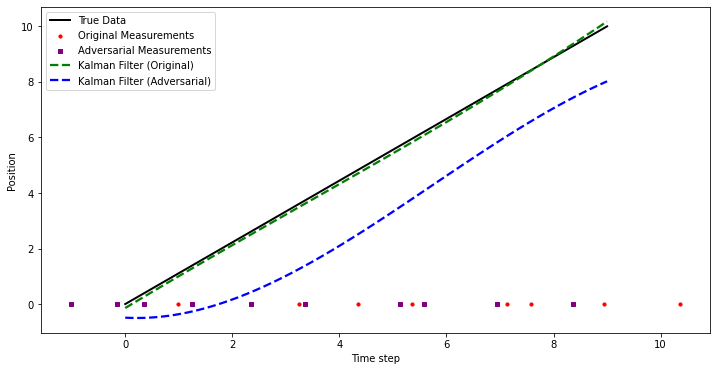

1.6867258968979764
Dimension: 2


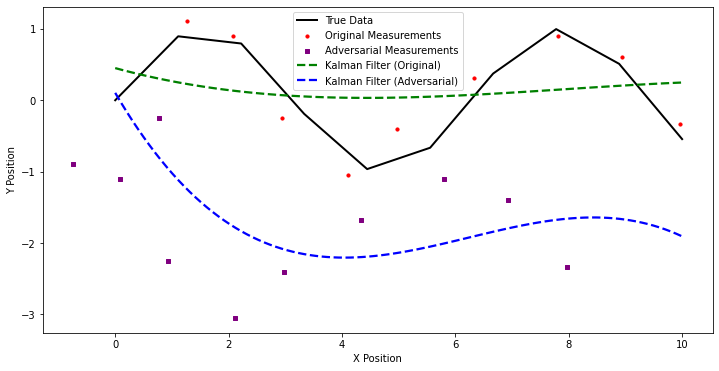

1.6864084119464136
Dimension: 3


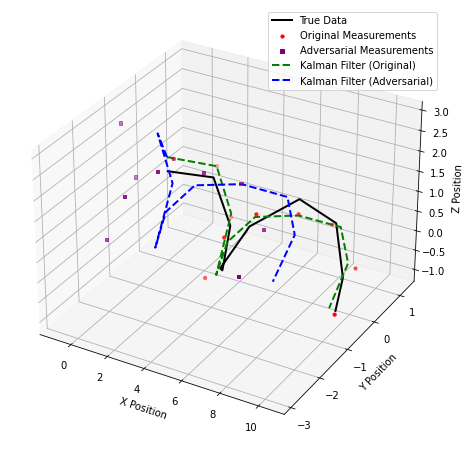

1.649937445732017


In [40]:
n_samples = 10
epsilon = 2

for dim in range(1, 4):
    # Initialize system and generate synthetic data
    F, G, H, Q, R, x_true, z = initialize_system_and_generate_data(dim, n_samples)

    # Initial state and covariance
    x0 = z[0]
    P0 = 10 * np.eye(dim)

    # Apply Kalman filter
    x_est = kalman_filter(z, x0, P0, F, G, H, Q, R, dim)

    # Generate adversarial perturbations and apply them to the measurements
    delta_z = fgsm_adversarial_perturbation(z, x0, P0, F, G, H, Q, R, epsilon, dim)

    # Update measurements with adversarial perturbations
    z_adv = z + delta_z

    # Apply Kalman filter to adversarial measurements
    x_est_adv = kalman_filter(z_adv, x0, P0, F, G, H, Q, R, dim)

    # Plot the data
    print(f"Dimension: {dim}")
    plot_data(dim, x_true, z, z_adv, x_est, x_est_adv)

    
    # Calculate the mean squared error for the original measurements
    mse_original = mean_absolute_error(x_true, x_est)

    # Calculate the mean squared error for the adversarial measurements
    mse_adversarial = mean_absolute_error(x_true, x_est_adv)

    # Calculate the performance change
    performance_change = mse_adversarial - mse_original
    print(performance_change)


Dimension: 1


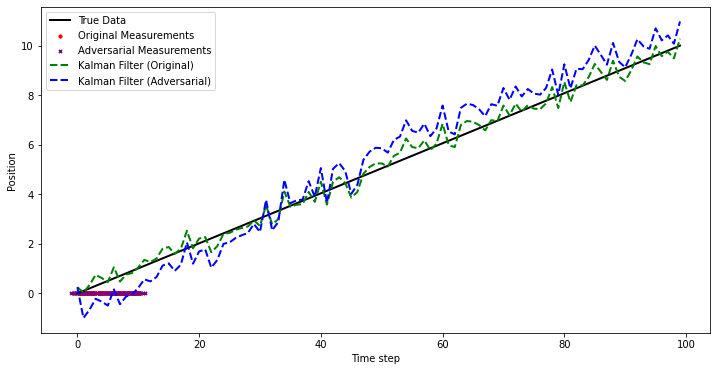

1.7445197448333771
Dimension: 2


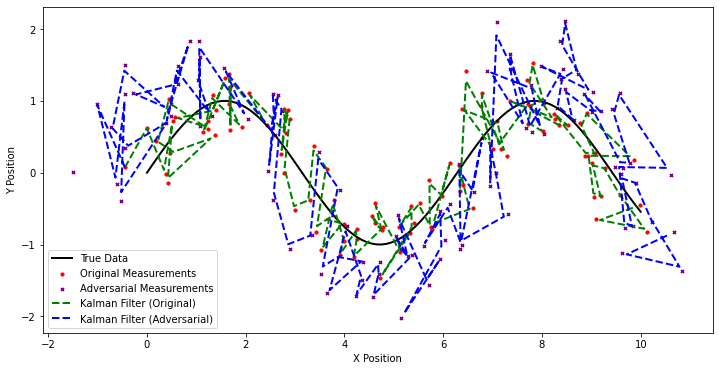

1.7445197448333771
Dimension: 3


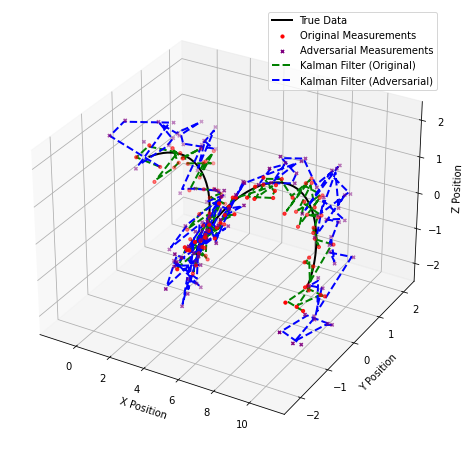

1.7445197448333771


In [6]:
n_samples = 100
epsilon = 2

for dim in range(1, 4):
    # Initialize system and generate synthetic data
    F, G, H, Q, R, x_true, z = initialize_system_and_generate_data(dim, n_samples)

    # Initial state and covariance
    x0 = z[0]
    P0 = 10 * np.eye(dim)

    # Apply Kalman filter
    x_est = kalman_filter(z, x0, P0, F, G, H, Q, R, dim)

    # Generate adversarial perturbations and apply them to the measurements
    delta_z = adam_adversarial_perturbation(z, x0, P0, F, G, H, Q, R, dim, epsilon, alpha, beta_1, beta_2, num_iterations)

    # Update measurements with adversarial perturbations
    z_adv = z + delta_z

    # Apply Kalman filter to adversarial measurements
    x_est_adv = kalman_filter(z_adv, x0, P0, F, G, H, Q, R, dim)

    # Plot the data
    print(f"Dimension: {dim}")
    plot_data(dim, x_true, z, z_adv, x_est, x_est_adv)
    print(performance_change)

In [14]:
n_samples = 100

results = []

for epsilon in np.arange(0, 10.5, 0.5):
    dim = 2
    # Initialize system and generate synthetic data
    F, G, H, Q, R, x_true, z = initialize_system_and_generate_data(dim, n_samples)

    # Initial state and covariance
    x0 = z[0]
    P0 = 10 * np.eye(dim)

    # Apply Kalman filter
    x_est = kalman_filter(z, x0, P0, F, G, H, Q, R, dim)

    # Generate adversarial perturbations using FGSM and apply them to the measurements
    delta_z_fgsm = fgsm_adversarial_perturbation(z, x0, P0, F, G, H, Q, R, epsilon, dim)
    z_fgsm = z + delta_z_fgsm
    x_est_fgsm = kalman_filter(z_fgsm, x0, P0, F, G, H, Q, R, dim)
    mse_original_fgsm = mean_absolute_error(x_true, x_est_fgsm)
    mse_adversarial_fgsm = mean_absolute_error(x_true, x_est_adv)
    performance_change_fgsm = np.abs(mse_adversarial_fgsm - mse_original_fgsm)

    # Generate adversarial perturbations using Adam and apply them to the measurements
    delta_z_adam = adam_adversarial_perturbation(z, x0, P0, F, G, H, Q, R, dim, epsilon, alpha, beta_1, beta_2, num_iterations)
    z_adam = z + delta_z_adam
    x_est_adam = kalman_filter(z_adam, x0, P0, F, G, H, Q, R, dim)
    mse_original_adam = mean_absolute_error(x_true, x_est_adam)
    mse_adversarial_adam = mean_absolute_error(x_true, x_est_adam)
    performance_change_adam = np.abs(mse_adversarial_adam - mse_original_adam)

    results.append((epsilon, mse_original_fgsm, mse_adversarial_fgsm, performance_change_fgsm, mse_original_adam, mse_adversarial_adam, performance_change_adam))

# Create a results table
df_results = pd.DataFrame(results, columns=['Epsilon', 'MAE (Original, FGSM)', 'MAE (Adversarial, FGSM)', 'Performance Change (FGSM)', 'MAE (Original, Adam)', 'MAE (Adversarial, Adam)', 'Performance Change (Adam)'])




In [15]:
df_results

,Epsilon,"MAE (Original, FGSM)","MAE (Adversarial, FGSM)",Performance Change (FGSM),"MAE (Original, Adam)","MAE (Adversarial, Adam)",Performance Change (Adam)
0,0.0,0.216888,4.501049,4.284161,0.216888,0.216888,0.0
1,0.5,0.367877,4.501049,4.133171,0.475711,0.475711,0.0
2,1.0,0.995489,4.501049,3.505560,0.540304,0.540304,0.0
3,1.5,1.486134,4.501049,3.014915,0.553521,0.553521,0.0
4,2.0,1.943372,4.501049,2.557677,0.522955,0.522955,0.0
5,2.5,2.467732,4.501049,2.033317,0.526988,0.526988,0.0
6,3.0,2.961191,4.501049,1.539858,0.533641,0.533641,0.0
7,3.5,3.459086,4.501049,1.041962,0.485591,0.485591,0.0
8,4.0,3.947561,4.501049,0.553488,0.503574,0.503574,0.0
9,4.5,4.461159,4.501049,0.039890,0.546486,0.546486,0.0
